# Load data

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import requests

In [2]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
for file in ['time_series_covid19_confirmed_global.csv',
             'time_series_covid19_deaths_global.csv',
             'time_series_covid19_recovered_global.csv',
             'time_series_covid19_confirmed_US.csv',
             'time_series_covid19_deaths_US.csv']:
    print('Downloading {} ...'.format(file))
    get_data = requests.get(url + file)
    open(file, 'wb').write(get_data.content)

In [3]:
# load covid cases
confirmed_global = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed_global.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,55445,55473,55492,55514,55518,55540,55557,55575,55580,55604
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,90835,91987,93075,93850,94651,95726,96838,97909,99062,100246
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,110303,110513,110711,110894,111069,111247,111418,111600,111764,111917
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,10427,10463,10503,10538,10555,10583,10610,10645,10672,10699
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,20294,20329,20366,20381,20389,20400,20452,20478,20499,20519


In [4]:
# prepare dataframe
confirmed_global_country = confirmed_global.groupby(['Country/Region']).sum()
confirmed_global_country = confirmed_global_country.drop(columns = ['Lat','Long'])
confirmed_global_country = confirmed_global_country.T
confirmed_global_country.index = pd.to_datetime(confirmed_global_country.index)
confirmed_global_country.columns.name = None
confirmed_global_country.index.name = None
confirmed_global_country['World'] = confirmed_global_country.sum(axis=1)
confirmed_global_country_first = confirmed_global_country[:1]
confirmed_global_country = confirmed_global_country.diff()
confirmed_global_country = confirmed_global_country.dropna()
confirmed_global_country.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe,World
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,98.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,286.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,492.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,685.0
2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,809.0


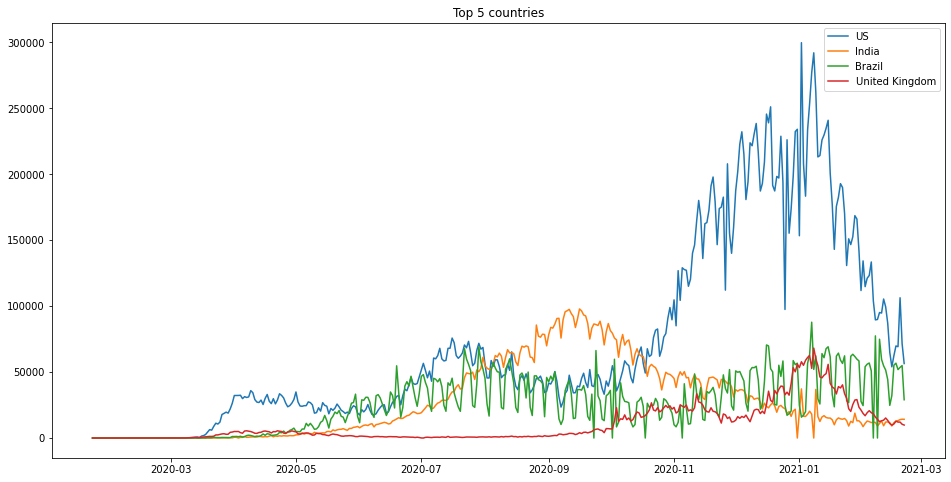

In [5]:
# plot top new cases countries
idx_top100 = confirmed_global_country.sum().sort_values(ascending=False).index[:100]
plt.figure(figsize=(16,8))
N = 5
plt.plot(confirmed_global_country[idx_top100[1:N]])
plt.legend(idx_top100[1:N])
plt.title('Top {} countries'.format(N))
plt.show()

In [6]:
train=confirmed_global_country[idx_top100[0:5].append(pd.Index(['Finland']))]
train.index.freq = 'D'
train_first = confirmed_global_country_first[idx_top100[0:5].append(pd.Index(['Finland']))]
train = train.dropna()

# Forecast

In [7]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [8]:
# Engineer new features: lags, rolling mean, diff and dates 
# all features are shifted by predict_days number to avoid data leak into prediction
def feature_engineering(df, predict_days = 7, lag_list = [0, 1, 7], drop_NAN = True, predict_future = False):
    df_new=df.copy()
    for feature in df.columns:
        for lag in lag_list:
            if predict_future:
                try: tmp
                except NameError:
                    tmp = pd.DataFrame({}, index=pd.date_range(train.index[-1]+pd.Timedelta(days=1), periods=predict_days, freq='D'))
                    df_new = df_new.append(tmp)
                df_new[feature + '_' + str(lag + predict_days)] = df_new[feature].shift(lag + predict_days)
                df_new[feature + '_rolling_' + str(lag + predict_days)] = df_new[feature + '_' + str(lag + predict_days)].rolling(7).mean()
                
            else:
                df_new[feature + '_' + str(lag + predict_days)] = df_new[feature].shift(lag + predict_days)
                df_new[feature + '_rolling_' + str(lag + predict_days)] = df_new[feature + '_' + str(lag + predict_days)].rolling(7).mean()
                
        df_new[feature + '_diff_' + str(0 + predict_days)] = df_new[feature + '_' + str(0 + predict_days)].diff(1)
        df_new[feature + '_diff_' + str(7 + predict_days)] = df_new[feature + '_' + str(0 + predict_days)].diff(7)
    
    if drop_NAN:
        df_new = df_new[lag + predict_days :]
        df_new = df_new.dropna()
            
        
    df_new['Day_year'] = df_new.index.dayofyear
    df_new['Day_week'] = df_new.index.dayofweek
    df_new['Day'] = df_new.index.day
    df_new['Month'] = df_new.index.month
    
    return df_new

In [9]:
# Previously it was also loading google search statistics but it's not informative these days
#training_columns = ['World','google_sum']
training_columns = ['World']
predict_days = 14
#lag_list = [0]
lag_list = range(predict_days)

train_set = feature_engineering(train['2020-01':][training_columns], 
                                predict_days = predict_days, 
                                lag_list = lag_list, 
                                drop_NAN = True, 
                                predict_future = True)

X_train   = train_set.drop(training_columns, axis=1)[:-predict_days]
y_train   = train_set[training_columns[0]][:-predict_days]
X_predict = train_set.drop(training_columns, axis=1)[-predict_days:]
y_predict   = train_set[training_columns[0]][-predict_days:]
train_set.head()

,World,World_14,World_rolling_14,World_15,World_rolling_15,World_16,World_rolling_16,World_17,World_rolling_17,World_18,...,World_26,World_rolling_26,World_27,World_rolling_27,World_diff_14,World_diff_21,Day_year,Day_week,Day,Month
2020-02-25,853.0,2042.0,2987.571429,2609.0,3268.857143,3030.0,3339.000000,2734.0,3584.571429,3593.0,...,2068.0,1082.857143,589.0,801.428571,-567.0,-1969.0,56,1,25,2
2020-02-26,977.0,418.0,2512.285714,2042.0,2987.571429,2609.0,3268.857143,3030.0,3339.000000,2734.0,...,1692.0,1283.714286,2068.0,1082.857143,-1624.0,-3327.0,57,2,26,2
2020-02-27,1360.0,15153.0,4225.571429,418.0,2512.285714,2042.0,2987.571429,2609.0,3268.857143,3030.0,...,2111.0,1515.000000,1692.0,1283.714286,14735.0,11993.0,58,3,27,2
2020-02-28,1386.0,6527.0,4644.714286,15153.0,4225.571429,418.0,2512.285714,2042.0,2987.571429,2609.0,...,4749.0,2095.571429,2111.0,1515.000000,-8626.0,2934.0,59,4,28,2
2020-02-29,1891.0,2143.0,4560.285714,6527.0,4644.714286,15153.0,4225.571429,418.0,2512.285714,2042.0,...,3100.0,2422.857143,4749.0,2095.571429,-4384.0,-591.0,60,5,29,2


### Forecast with ensembles 

RF score on train: 0.99 on test: -17.09
GB score on train: 1.00 on test: -14.86


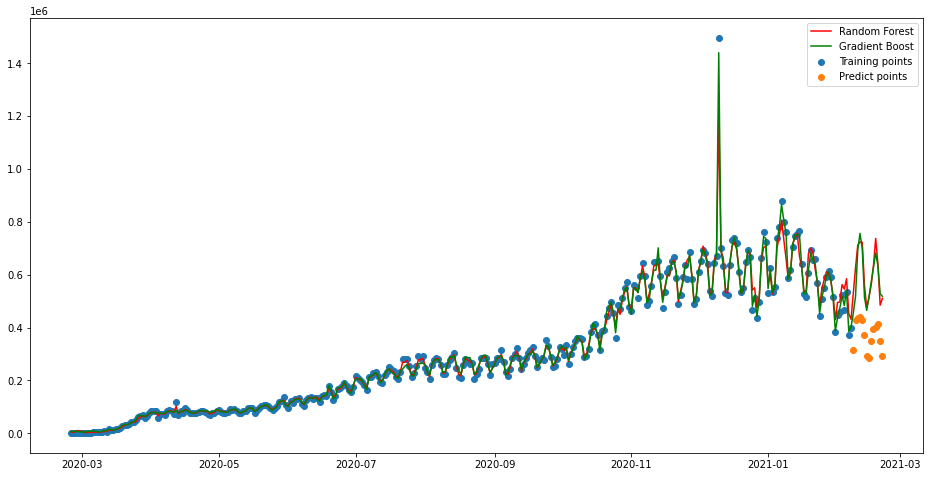

In [10]:
model_rf  = RandomForestRegressor()
model_gb  = GradientBoostingRegressor()
model_svr = make_pipeline(StandardScaler(), SVR(C=100000,epsilon=0.1))
model_knn = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=3))

model_rf.fit(X_train,y_train)
model_gb.fit(X_train,y_train)

pred_rf = model_rf.predict(pd.concat([X_train, X_predict]))
pred_gb = model_gb.predict(pd.concat([X_train, X_predict]))
print('RF score on train: {:0.2f} on test: {:0.2f}'.format(model_rf.score(X_train,y_train), model_rf.score(X_predict,y_predict)))
print('GB score on train: {:0.2f} on test: {:0.2f}'.format(model_gb.score(X_train,y_train), model_gb.score(X_predict,y_predict)))

plt.figure(figsize=(16,8))
plt.scatter(X_train.index,y_train, label='Training points')
plt.scatter(X_predict.index,y_predict, label='Predict points')
plt.plot(pd.concat([X_train,X_predict]).index,pred_rf,'r-', label = 'Random Forest')
plt.plot(pd.concat([X_train,X_predict]).index,pred_gb,'g-', label = 'Gradient Boost')
plt.legend()
plt.show()

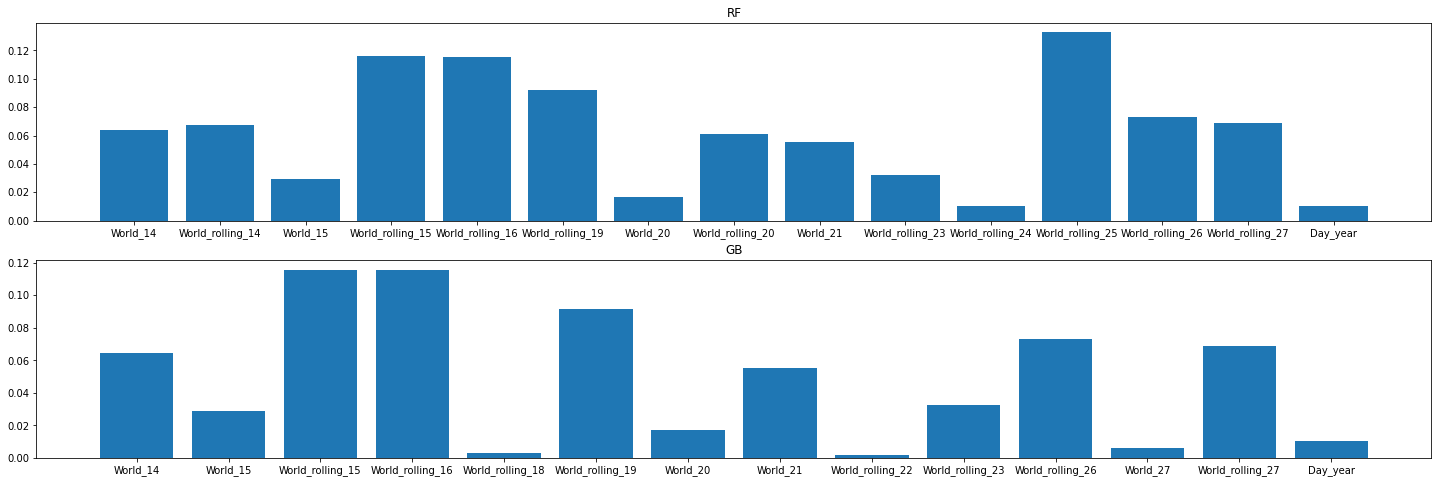

In [11]:
top_features_rf = model_rf.feature_importances_[model_rf.feature_importances_>0.01]
top_features_rf_labels = X_train.columns.values[model_rf.feature_importances_>0.01]
top_features_gb = model_rf.feature_importances_[model_gb.feature_importances_>0.01]
top_features_gb_labels = X_train.columns.values[model_gb.feature_importances_>0.01]

plt.figure(figsize=(25,8))
plt.subplot(211)
plt.bar(range(len(top_features_rf)), top_features_rf, tick_label = top_features_rf_labels)
plt.title('RF')
plt.subplot(212)
plt.bar(range(len(top_features_gb)), top_features_gb, tick_label = top_features_gb_labels)
plt.title('GB')
plt.show()

### Forecast with Prophet

In [12]:
from fbprophet import Prophet

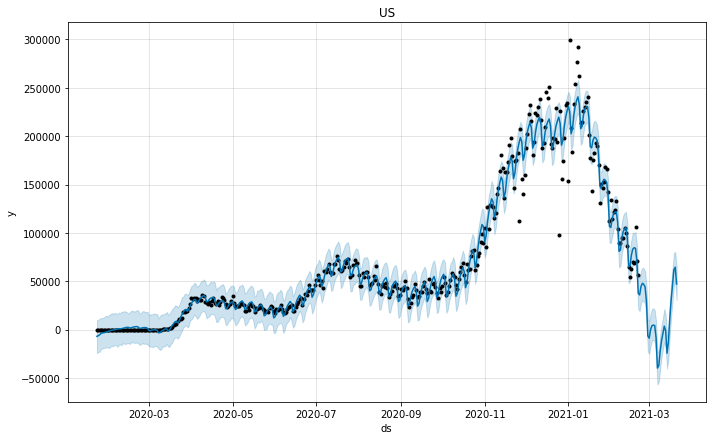

In [13]:
df_prophet = pd.DataFrame()
country = 'US'
start_data='2020-01'
df_prophet['ds'] = train[start_data:].index
df_prophet['y']  = (train[start_data:][country].values)

model_prophet = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=True,  
    daily_seasonality=False,
    seasonality_mode='multiplicative')
model_prophet.fit(df_prophet);

df_prophet_future = model_prophet.make_future_dataframe(periods=28)
df_prophet_forecast = model_prophet.predict(df_prophet_future)
df_prophet_forecast.head()

model_prophet.plot(df_prophet_forecast)
plt.title(country)
plt.show()

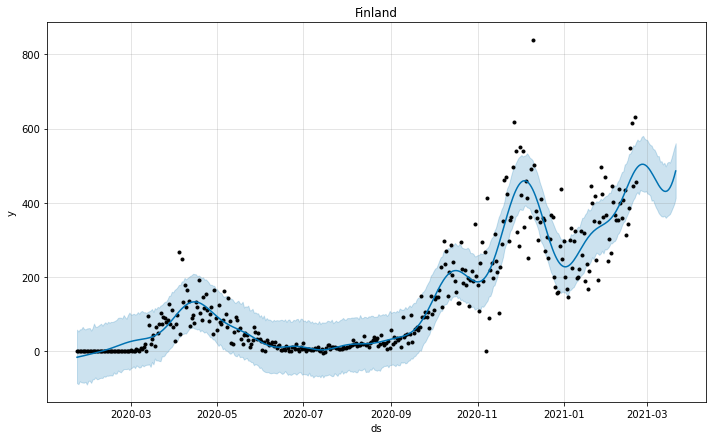

In [14]:
country = 'Finland'
start_data='2020-01'

df_prophet = pd.DataFrame()
df_prophet['ds'] = train[start_data:].index
df_prophet['y']  = (train[start_data:][country].values)

model_prophet = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,  
    daily_seasonality=False,
    seasonality_mode='multiplicative')
model_prophet.fit(df_prophet)

df_prophet_future = model_prophet.make_future_dataframe(periods=28)
df_prophet_forecast = model_prophet.predict(df_prophet_future)
df_prophet_forecast.head()

model_prophet.plot(df_prophet_forecast)
plt.title(country)
plt.show()

### Forecast with LSTM

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [16]:
# prepare lag features for input
def gen_features(data, lag = 7):
    X = []
    y = []
    for i in range(len(data) - lag):
        X.append(data[i : i + lag])
        y.append(data[i + lag])
    return np.array(X), np.array(y)

def gen_features_vector(data, lag = 7, predict_days = 7):
    X = []
    y = []
    for i in range(len(data) - lag - predict_days):
        X.append(data[i : i + lag])
        y.append(data[i + lag : i + lag + predict_days])
    return np.array(X), np.array(y)


In [17]:
# Vector output
country = 'Finland'
lag = 7*4
predict_days = 7*3

scaler = MinMaxScaler()
train_norm = scaler.fit_transform(train[[country]])

train_X, train_y = gen_features_vector(train_norm, lag, predict_days)
print('Shape X : {}\nShape y : {}'.format(train_X.shape, train_y.shape))

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
print('Shape X : {}\nShape y : {}'.format(train_X.shape, train_y.shape))

units = 128
num_epoch = 10


model = keras.Sequential()

# model 1 layer
#model.add(layers.LSTM(units, input_shape=(train_X.shape[1], 1)))

# model 2 layers
model.add(layers.LSTM(units, return_sequences=True, input_shape=(train_X.shape[1], 1)))
model.add(layers.LSTM(units))

# model bidirectional 1 layer
#model.add(layers.Bidirectional(layers.LSTM(units, input_shape=(train_X.shape[1], 1))))

model.add(layers.Dense(predict_days, activation = 'linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.fit(train_X, train_y, epochs=num_epoch, batch_size=1, verbose=1)

predict_vector = scaler.inverse_transform(model.predict(train_norm[-lag:].reshape((1, lag, 1))).reshape(-1,1))

Shape X : (347, 28, 1)
Shape y : (347, 21, 1)
Shape X : (347, 28, 1)
Shape y : (347, 21, 1)
Epoch 1/10
347/347 [==============================] - 7s 20ms/step - loss: 0.0153 - mae: 0.0842
Epoch 2/10
347/347 [==============================] - 7s 19ms/step - loss: 0.0112 - mae: 0.0729
Epoch 3/10
347/347 [==============================] - 10s 27ms/step - loss: 0.0099 - mae: 0.0674
Epoch 4/10
347/347 [==============================] - 9s 25ms/step - loss: 0.0093 - mae: 0.0637
Epoch 5/10
347/347 [==============================] - 8s 24ms/step - loss: 0.0090 - mae: 0.0638
Epoch 6/10
347/347 [==============================] - 7s 21ms/step - loss: 0.0085 - mae: 0.0615: 0s - loss: 0.0086
Epoch 7/10
347/347 [==============================] - 7s 21ms/step - loss: 0.0078 - mae: 0.0587
Epoch 8/10
347/347 [==============================] - 8s 24ms/step - loss: 0.0077 - mae: 0.0588
Epoch 9/10
347/347 [==============================] - 8s 23ms/step - loss: 0.0085 - mae: 0.0615
Epoch 10/10
347/347 [===

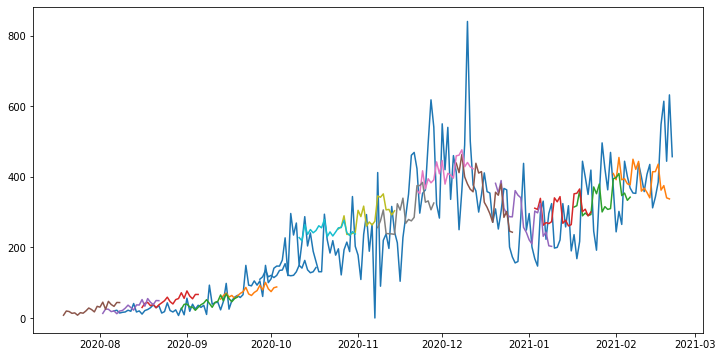

In [18]:
q_length = 200
q_step = 14

predict_train = scaler.inverse_transform(model.predict(train_X))

plt.figure(figsize=(12,6))
plt.plot(train[country][-q_length:])
for i in range(1,q_length,q_step):
    plt.plot(train.index[-predict_days-i:-i], predict_train[-i,:])
#plt.legend(['Train', 'Predict'])
plt.show()

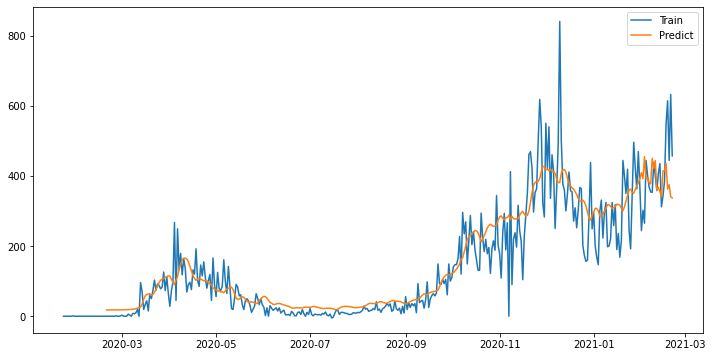

In [19]:
predict_train = scaler.inverse_transform(model.predict(train_X))

plt.figure(figsize=(12,6))
plt.plot(train[country])
plt.plot(train.index[lag:],np.append(predict_train[:,1], predict_train[-1,:], ))
plt.legend(['Train', 'Predict'])
plt.show()

In [20]:

scaler = MinMaxScaler()
train_norm = scaler.fit_transform(train[[country]])

train_X, train_y = gen_features(train_norm, lag)
print('Shape X : {}\nShape y : {}'.format(train_X.shape, train_y.shape))

train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
print('Shape X : {}\nShape y : {}'.format(train_X.shape, train_y.shape))

Shape X : (368, 28, 1)
Shape y : (368, 1)
Shape X : (368, 1, 28)
Shape y : (368, 1)


In [21]:
units = 128
model = keras.Sequential()
#model.add(layers.LSTM(units, input_shape=(1, train_X.shape[2])))

model.add(layers.LSTM(units, return_sequences=True, input_shape=(1, train_X.shape[2])))
model.add(layers.LSTM(units))

#model.add(layers.Bidirectional(layers.LSTM(units, input_shape=(1, train_X.shape[2]))))
#model.add(layers.LeakyReLU(alpha=0.5))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation = 'linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.fit(train_X, train_y, epochs=num_epoch, batch_size=1, verbose=1)


Epoch 1/10
368/368 [==============================] - 2s 5ms/step - loss: 0.0104 - mae: 0.0666
Epoch 2/10
368/368 [==============================] - 2s 5ms/step - loss: 0.0068 - mae: 0.0524A: 0s -
Epoch 3/10
368/368 [==============================] - 2s 5ms/step - loss: 0.0065 - mae: 0.0515
Epoch 4/10
368/368 [==============================] - 2s 5ms/step - loss: 0.0056 - mae: 0.0493
Epoch 5/10
368/368 [==============================] - 1s 4ms/step - loss: 0.0061 - mae: 0.0502
Epoch 6/10
368/368 [==============================] - 1s 4ms/step - loss: 0.0057 - mae: 0.0494
Epoch 7/10
368/368 [==============================] - 1s 4ms/step - loss: 0.0064 - mae: 0.0504
Epoch 8/10
368/368 [==============================] - 3s 7ms/step - loss: 0.0055 - mae: 0.0498
Epoch 9/10
368/368 [==============================] - 2s 4ms/step - loss: 0.0058 - mae: 0.0494
Epoch 10/10
368/368 [==============================] - 2s 5ms/step - loss: 0.0052 - mae: 0.0469


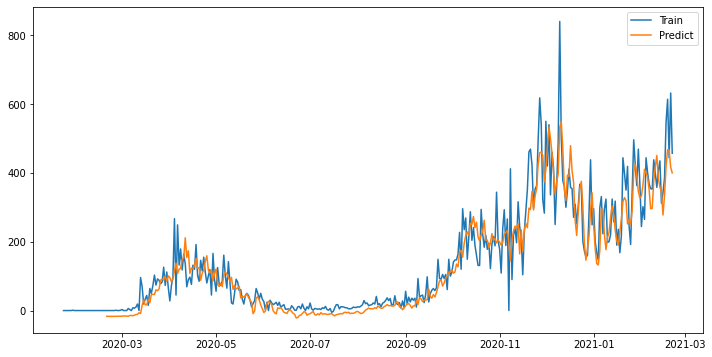

In [22]:
predict_train2 = scaler.inverse_transform(model.predict(train_X))

plt.figure(figsize=(12,6))
plt.plot(train[country])
plt.plot(train.index[lag:],predict_train2)
plt.legend(['Train', 'Predict'])
plt.show()

In [23]:
# future prediction

predict_future_norm = []
train_norm_new = train_norm.copy()
for i in range(predict_days):
    #print('i = {}'.format(i))
    future_X = np.reshape(train_norm_new[-lag:],(1,1,lag))
    predict_future_norm.append(model.predict(future_X))
    train_norm_new = np.append(train_norm_new,predict_future_norm[i])
predict_future_norm = np.array(predict_future_norm)  

predict_future = scaler.inverse_transform(predict_future_norm.reshape(-1,1))

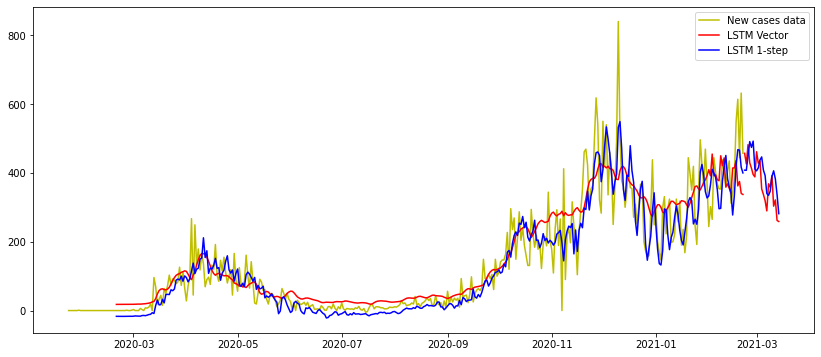

In [24]:

plt.figure(figsize=(14,6))
plt.plot(train[country],'y', label = 'New cases data')


plt.plot(train.index[lag:],np.append(predict_train[:,1], predict_train[-1,:], ), 'r', label = 'LSTM Vector')
plt.plot(pd.date_range(train.index[-1]+pd.Timedelta(days=1), periods=predict_days), predict_vector, 'r')

plt.plot(train.index[lag:],predict_train2,'b', label = 'LSTM 1-step')
plt.plot(pd.date_range(train.index[-1]+pd.Timedelta(days=1), periods=predict_days), predict_future,'b')


plt.legend()
#plt.legend(['Train', 'Future LSTM Vector','' ,'Future LSTM 1-step'])
plt.show()
#plt.savefig('Finland.png')